# Live 014 - PCA ( Principal Component Analysis )

### Nesse notebook, você vai encontrar os códigos para aplicar PCA sobre um modelo de redes neurais

## 0.0. Imports

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns

from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import decomposition   as d

from keras.models    import Sequential
from keras.layers    import Dense
from keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt

In [15]:
np.set_printoptions(suppress=True)

## 0.1. Load Dataset

In [16]:
# load dataset
df_raw = pd.read_csv( 'datasets/vehicle.csv' )
df_raw.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [17]:
df_raw['class'].value_counts( normalize=True )

car    0.507092
bus    0.257683
van    0.235225
Name: class, dtype: float64

In [18]:
# select only car and bus
df1 = df_raw[df_raw['class'].isin( ['car', 'bus'] )]

# cleaning
df1 = df1.dropna()

# features and response variable
X = df1.drop( 'class', axis=1 )
y = df1['class']

# split training and test
x, x_test, y, y_test = ms.train_test_split( X, y, test_size=0.1 )

# 1.0. Neural Network Model without PCA

In [6]:
# HOLD OUT
train_acc_list = []
val_acc_list = []
for i in range( 0, 50 ):
    # split training and validation
    x_train, x_val, y_train, y_val = ms.train_test_split( x, y, test_size=0.2 )

    # y for NN
    ohe = pp.OneHotEncoder()
    y_train = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()
    y_val = ohe.transform( y_val.values.reshape( -1, 1 ) ).toarray()


    # MLP: Neural Network 
    ## model definition
    model = Sequential()
    model.add( Dense( 2, input_dim=x_train.shape[1], activation='relu' ) ) # 2 neurons on Hidden Layer + Input Layer
    model.add( Dense( 2, activation='softmax' ) )

    ## model compile
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    ### model fit ( training)
    es = EarlyStopping( monitor='val_loss', patience=10 )
    history = model.fit( x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[es], verbose=0 )

    ## model evaluate
    _, train_acc = model.evaluate( x_train, y_train, verbose=0 )
    _, val_acc = model.evaluate( x_val, y_val, verbose=0 )

    #print( 'Train ACC:{} - Val ACC:{}'.format( train_acc, val_acc ) )
    train_acc_list.append( train_acc )
    val_acc_list.append( val_acc )

In [7]:
print( 'Train ACC AVG: {} +/- {}'.format( np.mean( train_acc_list ), np.std( train_acc_list ) ) )
print( 'Val ACC AVG: {} +/- {}'.format( np.mean( val_acc_list ), np.std( val_acc_list ) ) )

Train ACC AVG: 0.6880630618333816 +/- 0.04489897544269682
Val ACC AVG: 0.6858928608894348 +/- 0.06464902080101455


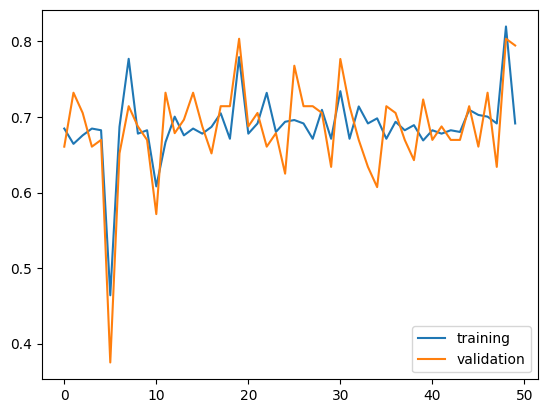

In [8]:
plt.plot( train_acc_list, label='training'  )
plt.plot( val_acc_list, label='validation' )
plt.legend()

In [9]:
y_test_nn = ohe.transform( y_test.values.reshape( -1, 1 ) ).toarray()
_, test_acc = model.evaluate( x_test, y_test_nn, verbose=0 )

print( 'Test ACC:{}'.format( test_acc ) )

Test ACC:0.6129032373428345


# 2.0. Neural Network Model with PCA

In [10]:
# split training and validation
x_train, x_val, y_train, y_val = ms.train_test_split( x, y, test_size=0.2 )

# PCA 
#standardization ( centralizao e rescala)
ss = pp.StandardScaler()
x_train_scaler = ss.fit_transform( x_train )
x_val_scaler = ss.transform( x_val )

# define the number of eigenvectors ( autovetor ) + eigenvalues ( autovalores )
pca = d.PCA().fit( x_train_scaler )
k = np.argmax( np.cumsum( pca.explained_variance_ratio_ ) > 0.99 )

# change data to new space
pca = d.PCA( k ).fit( x_train_scaler )

x_train = pca.transform( x_train_scaler )
x_val = pca.transform( x_val_scaler )

# y for NN
ohe = pp.OneHotEncoder()
y_train = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()
y_val = ohe.transform( y_val.values.reshape( -1, 1 ) ).toarray()


# MLP: Neural Network 
## model definition
model = Sequential()
model.add( Dense( 2, input_dim=x_train.shape[1], activation='relu' ) ) # 2 neurons on Hidden Layer + Input Layer
model.add( Dense( 2, activation='softmax' ) )

## model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

### model fit ( training)
es = EarlyStopping( monitor='val_loss', patience=10 )
history = model.fit( x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=[es], verbose=0 )

## model evaluate
_, train_acc = model.evaluate( x_train, y_train, verbose=0 )
_, val_acc = model.evaluate( x_val, y_val, verbose=0 )

print( 'Train ACC:{} - Val ACC:{}'.format( train_acc, val_acc ) )
train_acc_list.append( train_acc )
val_acc_list.append( val_acc )

Train ACC:0.9481981992721558 - Val ACC:0.9375


In [11]:
x_test_nn = pca.transform( ss.transform( x_test ) )
y_test_nn = ohe.transform( y_test.values.reshape( -1, 1 ) ).toarray()
_, test_acc = model.evaluate( x_test_nn, y_test_nn, verbose=0 )

print( 'Test ACC:{}'.format( test_acc ) )

Test ACC:0.8870967626571655


In [12]:
x_test_nn.shape

(62, 9)

# 4.0. How to determine the number of principal components ?

In [13]:
# return autovalores
pca.explained_variance_ratio_ #eigenvalues - autovalores

# accumulated sum of autovalores
np.cumsum( pca.explained_variance_ratio_ )

# determine the number of eigenvalues that represents 95% of the variability
k = np.argmax( np.cumsum( pca.explained_variance_ratio_ ) > 0.95 )

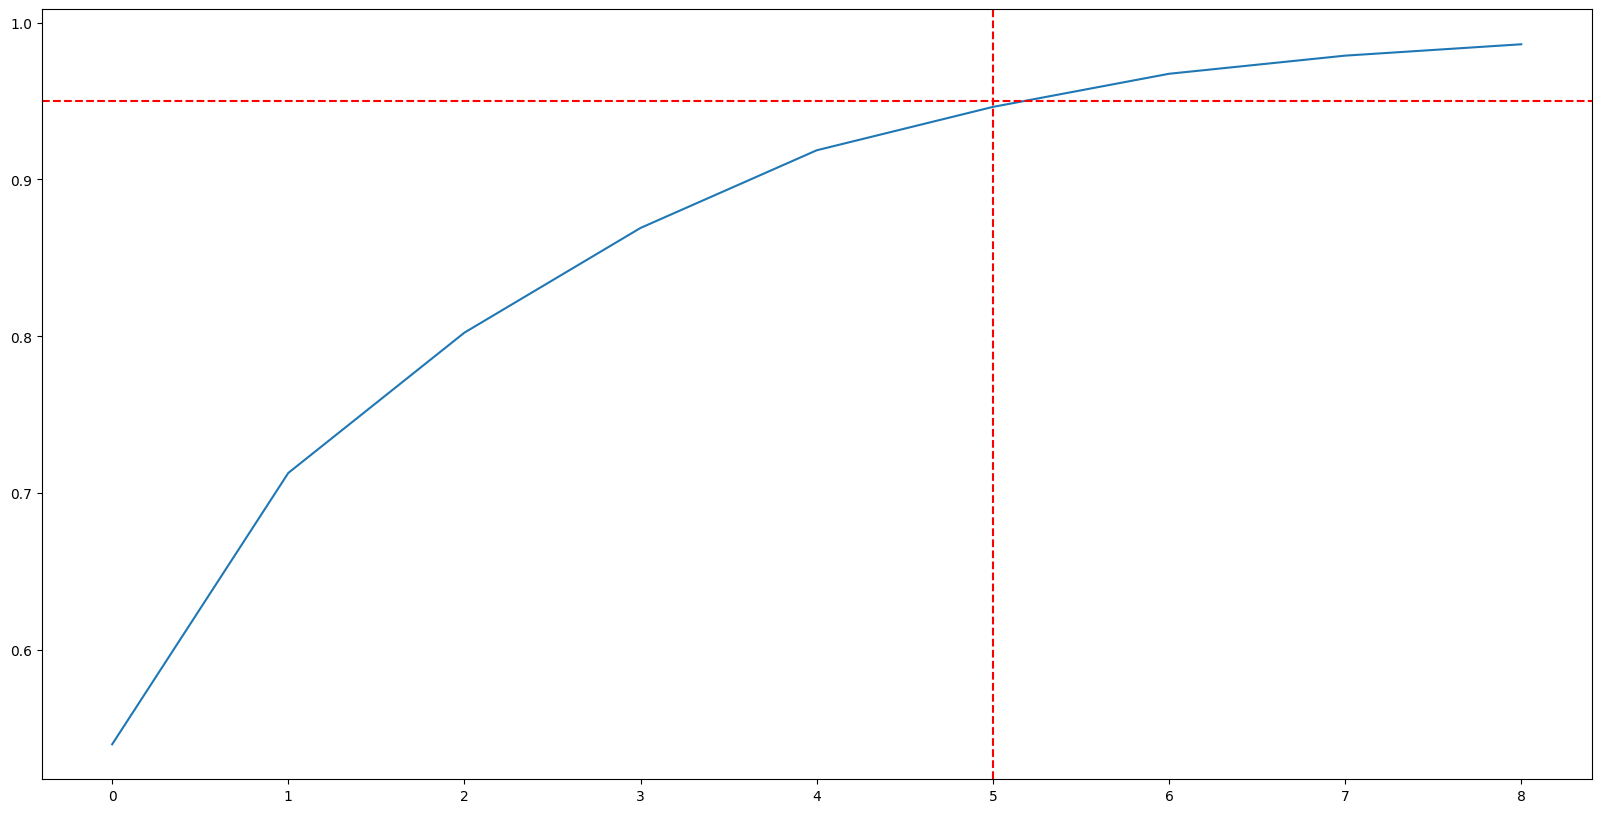

In [14]:
plt.figure(figsize=(20,10) )
plt.plot( np.cumsum( pca.explained_variance_ratio_ ) )
plt.axvline( 5, color='red', linestyle='--')
plt.axhline( 0.95, color='red', linestyle='--')

# 5.0. Why does PCA increase model performance?

## Data space
- Espaco mais organizado 

## Principais aplicações
- PCA = Processamento de Imagem - Redutor de ruido
- PCA antes de redes neurais

## Uso na estatística
- PCA = Estudo do Espacos

## PCA não permite explicabilidade
- PCA + NN = 95% - 0 Explicabilidade
- Random Forest - 85% - Explicabilidades

## PCA diminui o tamanho do modelo treinado em memória
- Random Forest - Treinada 22GB - U$ 5,00

- XGBoost -%4 - 200MB - U$0,04